In [1]:
!pip install deap

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install bitstring

     |████████████████████████████████| 195 kB 2.9 MB/s 
  Created wheel for bitstring: filename=bitstring-3.1.7-py3-none-any.whl size=37946 sha256=2ac1dfa825b7502b5d133af60fbf93dcaa2bc08a4188cea43a1e7cd31b42022a
  Stored in directory: /root/.cache/pip/wheels/de/df/5d/fb4c06c6f1469ae5a826a471cab0cbb5661f6fff9be1cd493e
Successfully built bitstring
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install transforms3d

     |████████████████████████████████| 62 kB 766 kB/s 
  Created wheel for transforms3d: filename=transforms3d-0.3.1-py3-none-any.whl size=59372 sha256=614c56984d611dfc31021d092d4e12b1d52564b63ac88408aea5ee4e0a6b6f3f
  Stored in directory: /root/.cache/pip/wheels/b5/b7/93/8985551f83720ce37548a5b543c75380bb707955a9c2c5d28c
Successfully built transforms3d
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
!pip install tsaug

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import stats 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [6]:
pwd

'/kaggle/working'

In [7]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [8]:
df = pd.read_csv('../input/covid-maroc-until-august-15/owid-covid-data.csv')

In [9]:
# Informations dur les données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36984 entries, 0 to 36983
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         36920 non-null  object 
 1   continent                        36691 non-null  object 
 2   location                         36984 non-null  object 
 3   date                             36984 non-null  object 
 4   total_cases                      36632 non-null  float64
 5   new_cases                        36632 non-null  float64
 6   total_deaths                     36632 non-null  float64
 7   new_deaths                       36632 non-null  float64
 8   total_cases_per_million          36568 non-null  float64
 9   new_cases_per_million            36568 non-null  float64
 10  total_deaths_per_million         36568 non-null  float64
 11  new_deaths_per_million           36568 non-null  float64
 12  new_tests         

In [10]:
# Les 5 premères lignes du dataset 
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [11]:
df[df.continent  == 'Africa'].shape
# soit 54 pays en afrique ,3 mois de COVID = approximativement 4800

(8414, 36)

In [12]:
#Taille des données de COVID pour le Maroc
df[df.location  == 'Morocco'].shape

(191, 36)

In [13]:
#Première date d'enregistrement de cas dans le monde 
df.date.min()

'2019-12-31'

In [14]:
# dernière date d'enregistrement pour notre datset
df.date.max()

'2020-08-15'

In [15]:
# Première date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.min()

'2020-02-07'

In [16]:
# dernière date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.max()

'2020-08-15'

In [17]:
df.date= pd.to_datetime(df['date'],format='%Y-%m-%d')

In [18]:
df=df[['new_cases','total_cases','total_deaths','new_deaths', 'population','date','location']]


In [19]:
df = df.fillna(df.median())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [20]:
df[(df.location  == 'Morocco')].tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23085,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
23086,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
23087,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
23088,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
23089,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
23090,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco
23091,1132.0,35195.0,533.0,17.0,36910558.0,2020-08-12,Morocco
23092,1499.0,36694.0,556.0,23.0,36910558.0,2020-08-13,Morocco
23093,1241.0,37935.0,584.0,28.0,36910558.0,2020-08-14,Morocco
23094,1306.0,39241.0,611.0,27.0,36910558.0,2020-08-15,Morocco


In [21]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    myNoise =  np.add(myNoise,abs(np.min(myNoise)))
    return X+myNoise

In [22]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    scalingFactor = np.add(scalingFactor,abs(np.min(scalingFactor)))
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [23]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

In [24]:
#df['month'] = df['date'].dt.month

In [25]:
nb_seq=4
n_out=7
nb_col=5

In [26]:
start_date = '2020-03-02'
end_date = '2020-07-13'
start_date2 ='2020-07-12'
end_date2 = '2020-08-15'

In [27]:
#mask = (covid_data['date'] >= start_date) & (covid_data['date'] <= end_date) &  (covid_data['location'].isin(['Morocco']))
mask1 = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))

In [28]:
mask2 = (df['date'] >= start_date2) & (df['date'] <= end_date2) &  (df['location'].isin(['Morocco']))

In [29]:
df.sort_values(by=['location'], inplace=True)


In [30]:
X_train = df.loc[mask1].sort_index(axis = 0) 
X_train.shape

(134, 7)

In [31]:
X_train.head(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco


In [32]:
X_train.tail(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23057,442.0,14771.0,242.0,7.0,36910558.0,2020-07-09,Morocco
23058,178.0,14949.0,242.0,0.0,36910558.0,2020-07-10,Morocco
23059,379.0,15328.0,243.0,1.0,36910558.0,2020-07-11,Morocco
23060,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
23061,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco


In [33]:
#Date to add test set 
data_add_test = X_train[X_train.location =='Morocco'].tail(nb_seq)

In [34]:
'''
# AUGMENTATION 

start_date = '2020-06-25'
end_date = '2020-07-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
X_1 = df.loc[mask].sort_index(axis = 0) 
X_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1

X_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)
X_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']
X_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)
X_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']

X_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)
X_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']
X_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)
X_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']

X_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)
X_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']
X_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)
X_4[['total_deaths']] = X_4['total_deaths'] + X_4['new_deaths']

X_5[['new_cases']] = DA_Jitter(X_5[['new_cases']], sigma=1000)
X_5[['total_cases']] = X_5['total_cases'] + X_5['new_cases']
X_5[['new_deaths']] = DA_Jitter(X_5[['new_deaths']], sigma=40)
X_5[['total_deaths']] = X_5['total_deaths'] + X_5['new_deaths']

X_6[['new_cases']] = DA_Jitter(X_6[['new_cases']], sigma=1000)
X_6[['total_cases']] = X_6['total_cases'] + X_6['new_cases']
X_6[['new_deaths']] = DA_Jitter(X_6[['new_deaths']], sigma=50)
X_6[['total_deaths']] = X_6['total_deaths'] + X_6['new_deaths']


#X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_6[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=2000)
#X_8[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=3000)
#X_4 = pd.DataFrame(X_4,columns=cols_need)
#print(X_1.shape)
X_train = pd.concat([X_train, X_2,X_3,X_4,X_5,X_6], ignore_index=True)
'''

"\n# AUGMENTATION \n\nstart_date = '2020-06-25'\nend_date = '2020-07-31'\nmask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))\nX_1 = df.loc[mask].sort_index(axis = 0) \nX_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1\n\nX_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)\nX_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']\nX_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)\nX_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']\n\nX_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)\nX_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']\nX_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)\nX_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']\n\nX_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)\nX_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']\nX_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)\nX_4[['total_deaths']] = X_4['total_deaths'

In [35]:
X_train.shape

(134, 7)

In [36]:
X_train.head(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco
22933,7.0,615.0,10.0,0.0,36910558.0,2020-03-07,Morocco
22934,7.0,615.0,10.0,0.0,36910558.0,2020-03-08,Morocco
22935,7.0,615.0,10.0,0.0,36910558.0,2020-03-09,Morocco
22936,7.0,615.0,10.0,0.0,36910558.0,2020-03-10,Morocco
22937,7.0,615.0,10.0,0.0,36910558.0,2020-03-11,Morocco


In [37]:
X_train.tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23052,319.0,13288.0,230.0,1.0,36910558.0,2020-07-04,Morocco
23053,534.0,13822.0,232.0,2.0,36910558.0,2020-07-05,Morocco
23054,393.0,14215.0,235.0,3.0,36910558.0,2020-07-06,Morocco
23055,114.0,14329.0,235.0,0.0,36910558.0,2020-07-07,Morocco
23056,0.0,14329.0,235.0,0.0,36910558.0,2020-07-08,Morocco
23057,442.0,14771.0,242.0,7.0,36910558.0,2020-07-09,Morocco
23058,178.0,14949.0,242.0,0.0,36910558.0,2020-07-10,Morocco
23059,379.0,15328.0,243.0,1.0,36910558.0,2020-07-11,Morocco
23060,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
23061,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco


In [38]:
X_test = df.loc[mask2].sort_index(axis = 0) 

X_test.shape

(35, 7)

In [39]:
X_test = pd.concat([pd.DataFrame(data_add_test),X_test], ignore_index=True)
X_test = X_test.sort_index(axis = 0)

In [40]:
X_test

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
0,178.0,14949.0,242.0,0.0,36910558.0,2020-07-10,Morocco
1,379.0,15328.0,243.0,1.0,36910558.0,2020-07-11,Morocco
2,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
3,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco
4,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
5,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco
6,191.0,15936.0,255.0,5.0,36910558.0,2020-07-14,Morocco
7,161.0,16097.0,257.0,2.0,36910558.0,2020-07-15,Morocco
8,165.0,16262.0,259.0,2.0,36910558.0,2020-07-16,Morocco
9,162.0,16424.0,260.0,1.0,36910558.0,2020-07-17,Morocco


In [41]:
X_test['timestamp'] = pd.to_datetime(X_test['date'], infer_datetime_format=True)
X_test.set_index('timestamp', inplace=True)

X_train['timestamp'] = pd.to_datetime(X_train['date'], infer_datetime_format=True)
X_train.set_index('timestamp', inplace=True)

In [42]:
X_train=X_train[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]

X_test=X_test[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]
Y_test=X_test[['new_cases']]

Y_train=X_train[['new_cases']]

In [43]:
days=X_test[nb_seq:].index
days=days.sort_values()

In [44]:
#days=days[nb_seq:]

In [45]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(134, 5)
(134, 1)
(39, 5)
(39, 1)


In [46]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2= MinMaxScaler(feature_range=(0, 1))

In [47]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [48]:

X_train=X_train
X_test=X_test
Y_train=Y_train
Y_test=Y_test

# ensure all data is float
X_train = X_train.astype('float32')
# ensure all data is float
X_test = X_test.astype('float32')
# ensure all data is float
Y_test = Y_test.astype('float32')
# ensure all data is float
Y_train = Y_train.astype('float32')

# normalize features

X_train= scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)
Y_train= scaler2.fit_transform(Y_train)
Y_test= scaler2.fit_transform(Y_test)

# reframe as supervised learning
# on doit toujours vers une conversion vers n_out ensuite con choisit le nombre de colonnes dont nous avons besoins
X_train = series_to_supervised(X_train, nb_seq, n_out)
X_test = series_to_supervised(X_test, nb_seq, n_out)
print(X_train)
print(X_train.shape)
print(X_test.shape)
Y_train = series_to_supervised(Y_train, nb_seq, n_out)
Y_test = series_to_supervised(Y_test, nb_seq, n_out)
print(Y_train.shape)
print(Y_test.shape)


     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var1(t-3)  \
4     0.010886   0.038999      0.040   0.000000        0.0   0.001555   
5     0.001555   0.000000      0.000   0.000000        0.0   0.010886   
6     0.010886   0.038999      0.040   0.000000        0.0   0.010886   
7     0.010886   0.038999      0.040   0.000000        0.0   0.001555   
8     0.001555   0.000064      0.000   0.000000        0.0   0.010886   
..         ...        ...        ...        ...        ...        ...   
123   0.272162   0.765434      0.884   0.066667        0.0   0.370140   
124   0.370140   0.780551      0.900   0.266667        0.0   0.377916   
125   0.377916   0.795986      0.912   0.200000        0.0   0.160187   
126   0.160187   0.802528      0.912   0.000000        0.0   0.517885   
127   0.517885   0.823679      0.916   0.066667        0.0   0.496112   

     var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  ...  var1(t+5)  var2(t+5)  \
4     0.000000      0.000   0.000000        0

In [49]:
print(X_test)

    var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var1(t-3)  \
4    0.012706   0.000000   0.000000   0.000000        0.0   0.162930   
5    0.162930   0.015602   0.002710   0.035714        0.0   0.039611   
6    0.039611   0.024411   0.008130   0.071429        0.0   0.031390   
7    0.031390   0.032768   0.021680   0.178571        0.0   0.039611   
8    0.039611   0.024411   0.008130   0.071429        0.0   0.031390   
9    0.031390   0.032768   0.021680   0.178571        0.0   0.022422   
10   0.022422   0.040631   0.035230   0.178571        0.0   0.000000   
11   0.000000   0.047258   0.040650   0.071429        0.0   0.002990   
12   0.002990   0.054051   0.046070   0.071429        0.0   0.000747   
13   0.000747   0.060720   0.048781   0.035714        0.0   0.105381   
14   0.105381   0.073152   0.059621   0.142857        0.0   0.095665   
15   0.095665   0.085049   0.073171   0.178571        0.0   0.044843   
16   0.044843   0.094146   0.084011   0.142857        0.0   0.12

In [50]:
#col_y_need_train = df.filter(regex=("d.*"))

In [51]:
#col_y_need_train=X_train.columns[[35,40,45,50,55,60,65]]
#col_y_need_test=X_test.columns[[35,40,45,50,55,60,65]]
X_train

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),...,var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var1(t+6),var2(t+6),var3(t+6),var4(t+6),var5(t+6)
4,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000000,0.000,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.004666,0.000254,0.004,0.066667,0.0
5,0.001555,0.000000,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.004666,0.000254,0.004,0.066667,0.0,0.001555,0.000318,0.004,0.000000,0.0
6,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.001555,0.000318,0.004,0.000000,0.0,0.001555,0.000381,0.004,0.000000,0.0
7,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000064,0.000,0.000000,0.0,...,0.001555,0.000381,0.004,0.000000,0.0,0.017107,0.001080,0.004,0.000000,0.0
8,0.001555,0.000064,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.017107,0.001080,0.004,0.000000,0.0,0.015552,0.001715,0.004,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.272162,0.765434,0.884,0.066667,0.0,0.370140,0.780551,0.900,0.266667,0.0,...,0.000000,0.910061,0.940,0.000000,0.0,0.687403,0.938135,0.968,0.466667,0.0
124,0.370140,0.780551,0.900,0.266667,0.0,0.377916,0.795986,0.912,0.200000,0.0,...,0.687403,0.938135,0.968,0.466667,0.0,0.276827,0.949441,0.968,0.000000,0.0
125,0.377916,0.795986,0.912,0.200000,0.0,0.160187,0.802528,0.912,0.000000,0.0,...,0.276827,0.949441,0.968,0.000000,0.0,0.589425,0.973514,0.972,0.066667,0.0
126,0.160187,0.802528,0.912,0.000000,0.0,0.517885,0.823679,0.916,0.066667,0.0,...,0.589425,0.973514,0.972,0.066667,0.0,0.332815,0.987106,0.980,0.133333,0.0


In [52]:
Y_train.head(5)

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
4,0.010886,0.001555,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666
5,0.001555,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555
6,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555
7,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107
8,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107,0.015552


In [53]:
#raise SystemExit("Stop right there!")

In [54]:
# regex : var[1-i]\(t\-\d{1,2}\)$
#i = 1 if nb_seq== 7 else 2 if nb_seq== 6 else 3 if nb_seq== 5 else 4 if nb_seq== 4 else 5 if nb_seq== 3 else 6 if nb_seq== 2 else 7 if nb_seq== 1 else 0
col_take= 'var[1-j]\(t\-[1-i]\)$'
col_take = col_take.replace("i", str(nb_seq))
col_take = col_take.replace("j", str(nb_col))
regex_find = col_take

In [55]:
col_x_need_train =X_train.filter(regex=regex_find,axis=1).head(1)

In [56]:
col_x_need_train

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
4,0.010886,0.038999,0.04,0.0,0.0,0.001555,0.0,0.0,0.0,0.0,0.010886,0.038999,0.04,0.0,0.0,0.010886,0.038999,0.04,0.0,0.0


In [57]:
#col_take2= 'var[1-i](\(t\+\d{1}\)|(\(t\)))$'
col_take2= 'var1(\(t\+\d{1}\)|(\(t\)))$'
#col_take2 = col_take2.replace("i", str(nb_seq))
regex_find2 = col_take2
Y_train.filter(regex=regex_find2,axis=1).head(1)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
4,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666


In [58]:
#raise SystemExit("Stop right there!")

In [59]:
#col_x_need_train=X_train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]
#col_x_need_test=X_test.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]

In [60]:
#col_x_need_train

In [61]:
# drop columns we don't want to predict
Y_train = Y_train.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_test=Y_test.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_train
print(Y_train.shape)
print(Y_test.shape)


(124, 7)
(29, 7)


In [62]:
Y_train.head(5)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
4,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666
5,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555
6,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555
7,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107
8,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107,0.015552


In [63]:
# drop columns we don't want to predict
X_train = X_train.filter(regex=regex_find,axis=1)
X_test=X_test.filter(regex=regex_find,axis=1)
print(X_train.shape)
print(X_test.shape)
X_train


(124, 20)
(29, 20)


,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
4,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000000,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
5,0.001555,0.000000,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000064,0.000,0.000000,0.0
6,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000064,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
7,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000064,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
8,0.001555,0.000064,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.272162,0.765434,0.884,0.066667,0.0,0.370140,0.780551,0.900,0.266667,0.0,0.377916,0.795986,0.912,0.200000,0.0,0.160187,0.802528,0.912,0.000000,0.0
124,0.370140,0.780551,0.900,0.266667,0.0,0.377916,0.795986,0.912,0.200000,0.0,0.160187,0.802528,0.912,0.000000,0.0,0.517885,0.823679,0.916,0.066667,0.0
125,0.377916,0.795986,0.912,0.200000,0.0,0.160187,0.802528,0.912,0.000000,0.0,0.517885,0.823679,0.916,0.066667,0.0,0.496112,0.843940,0.920,0.066667,0.0
126,0.160187,0.802528,0.912,0.000000,0.0,0.517885,0.823679,0.916,0.066667,0.0,0.496112,0.843940,0.920,0.066667,0.0,0.830482,0.877858,0.928,0.133333,0.0


In [64]:
X_test

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
4,0.012706,0.000000,0.000000,0.000000,0.0,0.162930,0.015602,0.002710,0.035714,0.0,0.039611,0.024411,0.008130,0.071429,0.0,0.031390,0.032768,0.021680,0.178571,0.0
5,0.162930,0.015602,0.002710,0.035714,0.0,0.039611,0.024411,0.008130,0.071429,0.0,0.031390,0.032768,0.021680,0.178571,0.0,0.039611,0.024411,0.008130,0.071429,0.0
6,0.039611,0.024411,0.008130,0.071429,0.0,0.031390,0.032768,0.021680,0.178571,0.0,0.039611,0.024411,0.008130,0.071429,0.0,0.031390,0.032768,0.021680,0.178571,0.0
7,0.031390,0.032768,0.021680,0.178571,0.0,0.039611,0.024411,0.008130,0.071429,0.0,0.031390,0.032768,0.021680,0.178571,0.0,0.022422,0.040631,0.035230,0.178571,0.0
8,0.039611,0.024411,0.008130,0.071429,0.0,0.031390,0.032768,0.021680,0.178571,0.0,0.022422,0.040631,0.035230,0.178571,0.0,0.000000,0.047258,0.040650,0.071429,0.0
9,0.031390,0.032768,0.021680,0.178571,0.0,0.022422,0.040631,0.035230,0.178571,0.0,0.000000,0.047258,0.040650,0.071429,0.0,0.002990,0.054051,0.046070,0.071429,0.0
10,0.022422,0.040631,0.035230,0.178571,0.0,0.000000,0.047258,0.040650,0.071429,0.0,0.002990,0.054051,0.046070,0.071429,0.0,0.000747,0.060720,0.048781,0.035714,0.0
11,0.000000,0.047258,0.040650,0.071429,0.0,0.002990,0.054051,0.046070,0.071429,0.0,0.000747,0.060720,0.048781,0.035714,0.0,0.105381,0.073152,0.059621,0.142857,0.0
12,0.002990,0.054051,0.046070,0.071429,0.0,0.000747,0.060720,0.048781,0.035714,0.0,0.105381,0.073152,0.059621,0.142857,0.0,0.095665,0.085049,0.073171,0.178571,0.0
13,0.000747,0.060720,0.048781,0.035714,0.0,0.105381,0.073152,0.059621,0.142857,0.0,0.095665,0.085049,0.073171,0.178571,0.0,0.044843,0.094146,0.084011,0.142857,0.0


In [65]:
print(X_test.shape)

(29, 20)


In [66]:
nb_col=5

In [67]:
X_test.head(1)

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
4,0.012706,0.0,0.0,0.0,0.0,0.16293,0.015602,0.00271,0.035714,0.0,0.039611,0.024411,0.00813,0.071429,0.0,0.03139,0.032768,0.02168,0.178571,0.0


In [68]:

X_train=X_train.values
X_test=X_test.values

Y_train=Y_train.values
Y_test=Y_test.values

# reshape input to be 3D [samples, timesteps, features]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)


(29, 1, 20) (29, 7) (124, 1, 20) (124, 7)


In [69]:
'''
n_input = X_train.shape[1] * X_train.shape[2]
X_train= X_train.reshape((X_train.shape[0], n_input))
n_input2 = X_test.shape[1] * X_test.shape[2]
X_test= X_test.reshape((X_test.shape[0], n_input2))
'''
print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)

(29, 1, 20) (29, 7) (124, 1, 20) (124, 7)


In [70]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [71]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [72]:
best_score = 0
best_sequence = 0
model_name=  ''
history_model= ''

In [73]:
from tensorflow.keras.callbacks import EarlyStopping
import math
from math import sqrt
dropout_tab =[0.0,0.15,0.2,0.25,0.4,0.45,0.5,0.6]
def train_evaluate(ga_individual_solution): 
    global best_score, model_name ,best_sequence ,sequences_size
    
    # Decode GA solution to integer for window_size and num_units
    cnn_units1_bits = BitArray(ga_individual_solution[0:8])
    #cnn_units2_bits = BitArray(ga_individual_solution[7:14])
    #cnn_units3_bits = BitArray(ga_individual_solution[15:22])
    cnn_units1 = cnn_units1_bits.uint
    #cnn_units2 =  cnn_units2_bits.uint
    #cnn_units3 =  cnn_units3_bits.uint

    cnn_units1 = 1 if cnn_units1 == 0  else cnn_units1
    #cnn_units2  = 1 if cnn_units2 == 0  else cnn_units2 

    #print('\nUnits CNN1: ',cnn_units1,'Units CNN2: ',cnn_units2,',Sequence size: ',nb_seq)
    print('\nUnits CNN1: ',cnn_units1,',Sequence size: ',nb_seq)
      
    # convert into input/output
    print(X_train.shape)
    model = keras.Sequential()  
 
    #initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)   
    model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='relu' ,input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='relu'))
    #model.add(layers.Conv1D(cnn_units3,2,padding='same',strides=1, activation='tanh'))
    model.add(layers.Flatten())
    #model.add(Dense(100))
    #model.add(Dense(50))
    #model.add(Dense(cnn_units3))
    #model.add(Dense(cnn_units3))
    model.add(Dropout(0.2))
    model.add(Dense(n_out))

    '''
    model.add(LSTM(cnn_units1, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(cnn_units2, activation='relu'))
    model.add(Dense(n_out))
    '''
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, Y_train, epochs=6,batch_size=1, validation_data=(X_test[[0,7,14,21,28]], Y_test[[0,7,14,21,28]]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)
    model.summary()
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    pred_train = model.predict(X_train)
    print(pred_train.shape)
    pred_train = pred_train.reshape(-1,n_out)

    print(Y_train.shape)
    print(pred_train.shape)
    score_train ,scores_train = evaluate_forecasts(scaler2.inverse_transform(Y_train) ,scaler2.inverse_transform(pred_train))
    summarize_scores('score_train', score_train, scores_train) 
    
    #Normalisation des X
    print(X_test.shape)
    #Prédiction sur les données de Test
    prediction = model.predict(X_test[[0,7,14,21,28]]) 
    prediction = prediction.reshape(-1, n_out)

   
    score_test ,scores_test = evaluate_forecasts(scaler2.inverse_transform(Y_test[[0,7,14,21,28]]) ,scaler2.inverse_transform(prediction))
    summarize_scores('score_test', score_test, scores_test) 
    # le score 
    score_val = score_test
    best_score = score_val if best_score == 0 else best_score
    if(best_score >= score_val):
      best_score= score_val
      model_name= model
      history_model= history
    # Calculate the RMSE score as fitness score for GA
    #rmse =  np.sqrt(mean_squared_error(prediction_test.true_value, prediction_test.predict))
    print('\nRMSE test: ', score_test ,'\n')
    #print('Validation Score: ', score_val,'\n')
    
    return best_score,


Units CNN1:  247 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0872
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0741
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0705
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0673
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0583
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0207 - val_loss: 0.0658
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 247)            10127     
_________________________________________________________________
flatten (Flatten)            (None, 247)               0         
______

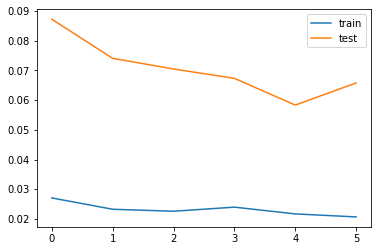

(124, 7)
(124, 7)
(124, 7)
score_train: [183.451] 169.8, 177.3, 187.4, 184.9, 181.9, 186.2, 195.6
(29, 1, 20)
score_test: [343.163] 298.9, 241.6, 132.1, 207.1, 476.5, 418.9, 462.3

RMSE test:  343.1631790567635 


Units CNN1:  178 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0677
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0806
Epoch 3/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0238 - val_loss: 0.0772
Epoch 4/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0221 - val_loss: 0.0702
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0610
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0617
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              

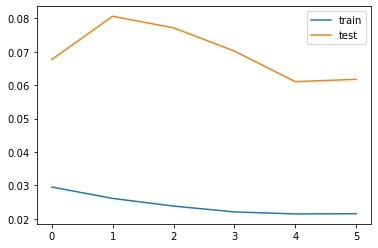

(124, 7)
(124, 7)
(124, 7)
score_train: [185.847] 171.2, 178.6, 184.4, 185.0, 187.5, 193.4, 199.5
(29, 1, 20)
score_test: [332.468] 365.7, 271.0, 155.3, 227.0, 409.8, 392.9, 410.6

RMSE test:  332.4677426317813 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.1105
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0809
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0681
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0706
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0689
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0648
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              

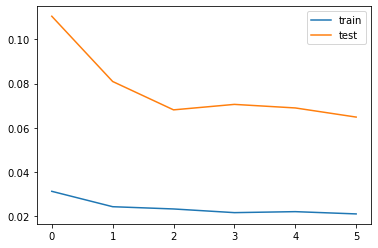

(124, 7)
(124, 7)
(124, 7)
score_train: [189.289] 169.2, 196.3, 178.2, 195.8, 182.4, 206.4, 194.2
(29, 1, 20)
score_test: [340.621] 325.7, 180.8, 154.2, 227.8, 406.9, 485.3, 443.5

RMSE test:  340.621093116263 


Units CNN1:  254 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 4ms/step - loss: 0.0306 - val_loss: 0.0914
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0713
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0624
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0597
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0727
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0563
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              P

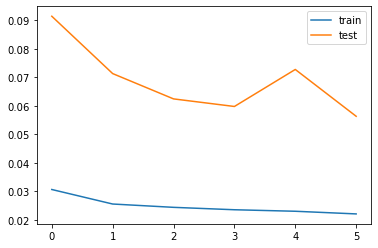

(124, 7)
(124, 7)
(124, 7)
score_train: [181.479] 166.5, 176.2, 177.6, 180.4, 179.7, 187.0, 201.1
(29, 1, 20)
score_test: [317.453] 284.0, 227.7, 144.3, 208.3, 434.0, 369.4, 428.9

RMSE test:  317.4531055845942 


Units CNN1:  191 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.1170
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.1004
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0759
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0751
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0755
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0762
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              

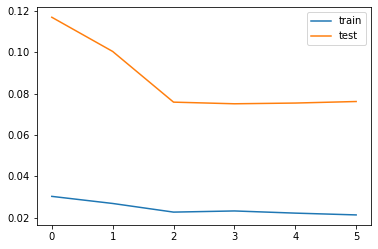

(124, 7)
(124, 7)
(124, 7)
score_train: [186.729] 179.7, 180.9, 186.8, 183.9, 182.4, 189.4, 202.9
(29, 1, 20)
score_test: [369.347] 275.8, 234.6, 155.4, 247.0, 510.3, 454.5, 521.2

RMSE test:  369.3472537381858 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0879
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0748
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0743
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0762
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0210 - val_loss: 0.0636
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0703
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              

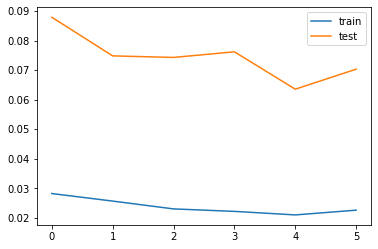

(124, 7)
(124, 7)
(124, 7)
score_train: [182.854] 176.9, 179.3, 180.0, 182.6, 178.6, 192.3, 189.7
(29, 1, 20)
score_test: [354.820] 354.2, 287.4, 131.1, 192.5, 459.4, 415.5, 485.0

RMSE test:  354.8201139066888 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0765
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0860
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0676
Epoch 4/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0228 - val_loss: 0.0623
Epoch 5/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0228 - val_loss: 0.0550
Epoch 6/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0221 - val_loss: 0.0725
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              

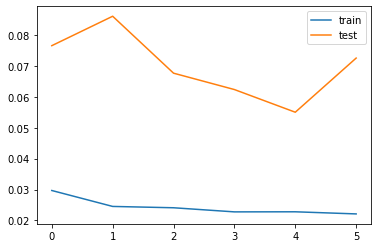

(124, 7)
(124, 7)
(124, 7)
score_train: [187.321] 173.8, 178.4, 186.8, 181.5, 194.9, 197.3, 196.9
(29, 1, 20)
score_test: [360.269] 301.5, 219.8, 147.4, 212.2, 481.7, 484.1, 486.0

RMSE test:  360.2691870474154 


Units CNN1:  247 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0844
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0773
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0736
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0772
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0863
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0800
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              

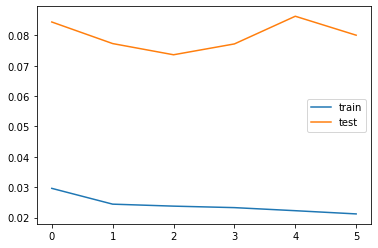

(124, 7)
(124, 7)
(124, 7)
score_train: [188.054] 186.6, 176.0, 184.1, 181.8, 189.2, 199.2, 198.4
(29, 1, 20)
score_test: [378.514] 372.4, 250.9, 150.0, 217.6, 510.7, 472.5, 497.4

RMSE test:  378.514456419644 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0888
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0775
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0698
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0760
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0608
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0715
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              P

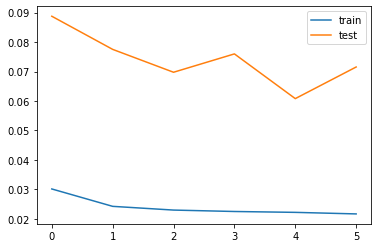

(124, 7)
(124, 7)
(124, 7)
score_train: [189.353] 185.6, 187.4, 192.7, 184.6, 178.3, 199.5, 196.6
(29, 1, 20)
score_test: [357.878] 403.3, 296.6, 157.4, 228.0, 490.0, 334.7, 465.7

RMSE test:  357.8775441649662 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.1048
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0606
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0664
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0656
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0678
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0683
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              

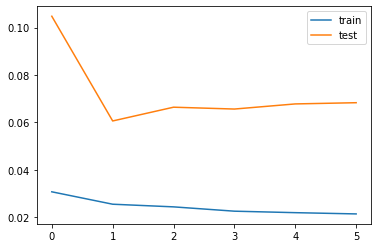

(124, 7)
(124, 7)
(124, 7)
score_train: [184.016] 171.0, 182.4, 181.7, 190.7, 180.0, 188.3, 193.0
(29, 1, 20)
score_test: [349.736] 332.5, 284.4, 148.2, 185.3, 451.0, 420.6, 477.5

RMSE test:  349.73623839048815 

gen	nevals	avg    	std    	min    	max    
0  	10    	323.027	8.95097	317.453	343.163

Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0892
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0700
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0625
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0748
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0540
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0710
Model: "sequential_10"
_________________________________

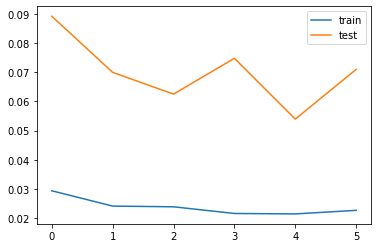

(124, 7)
(124, 7)
(124, 7)
score_train: [188.970] 171.6, 183.0, 181.3, 198.2, 190.8, 205.8, 190.1
(29, 1, 20)
score_test: [356.551] 346.9, 255.3, 150.2, 231.6, 475.9, 450.2, 446.2

RMSE test:  356.55104754107947 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0904
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0869
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0847
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0691
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0711
Epoch 6/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0225 - val_loss: 0.0762
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape            

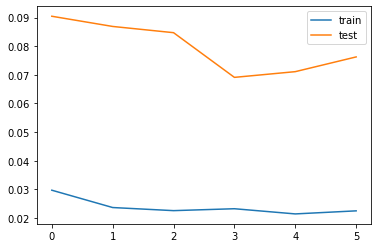

(124, 7)
(124, 7)
(124, 7)
score_train: [186.850] 172.5, 182.9, 180.6, 195.5, 179.6, 191.8, 203.2
(29, 1, 20)
score_test: [369.439] 350.9, 281.4, 146.2, 149.5, 480.3, 472.4, 505.5

RMSE test:  369.4386597451181 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 1s 5ms/step - loss: 0.0293 - val_loss: 0.1006
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0785
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0627
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0581
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0653
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0572
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape             

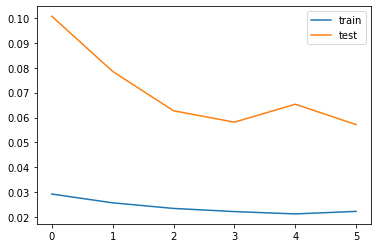

(124, 7)
(124, 7)
(124, 7)
score_train: [187.814] 188.1, 178.5, 181.2, 184.1, 191.0, 198.4, 192.6
(29, 1, 20)
score_test: [319.890] 245.3, 227.3, 138.2, 190.5, 433.6, 396.8, 451.3

RMSE test:  319.8903527903567 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0794
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0724
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0670
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0777
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0630
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0498
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape             

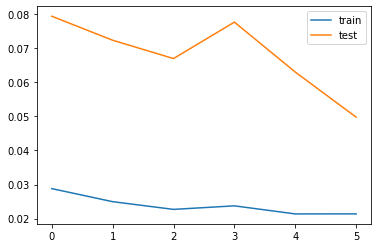

(124, 7)
(124, 7)
(124, 7)
score_train: [198.829] 210.6, 192.9, 198.1, 190.4, 179.3, 217.6, 200.4
(29, 1, 20)
score_test: [298.507] 223.5, 207.4, 159.8, 143.8, 411.4, 381.7, 411.9

RMSE test:  298.50741503060135 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0778
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0802
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0677
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0872
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0555
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0579
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape            

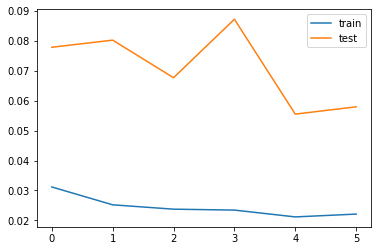

(124, 7)
(124, 7)
(124, 7)
score_train: [188.725] 180.1, 176.8, 181.8, 199.5, 197.5, 195.0, 189.1
(29, 1, 20)
score_test: [322.040] 264.3, 235.9, 148.9, 281.0, 385.0, 402.4, 435.0

RMSE test:  322.04027889289387 


Units CNN1:  126 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0868
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0938
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0788
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0814
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0774
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0760
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape            

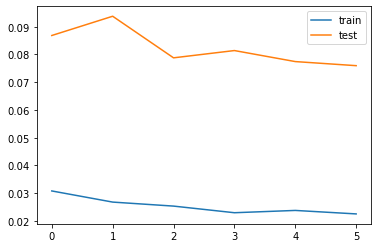

(124, 7)
(124, 7)
(124, 7)
score_train: [186.591] 180.5, 181.9, 182.0, 187.0, 184.4, 189.0, 200.7
(29, 1, 20)
score_test: [368.791] 328.5, 253.4, 147.3, 288.0, 464.0, 442.3, 514.2

RMSE test:  368.790767839965 

1  	6     	313.271	10.6177	298.507	332.468

Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0710
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0814
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0664
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0613
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0674
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0755
Model: "sequential_16"
_________________________________________________________________
Layer (type)

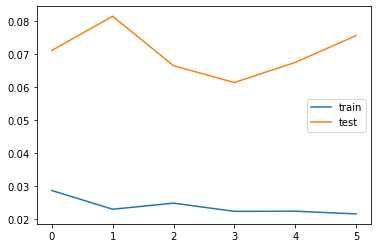

(124, 7)
(124, 7)
(124, 7)
score_train: [193.340] 176.1, 190.4, 204.1, 191.3, 208.7, 189.4, 191.6
(29, 1, 20)
score_test: [367.752] 342.0, 272.9, 177.7, 253.4, 537.6, 419.6, 440.9

RMSE test:  367.7519871920952 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.1030
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0812
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0649
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0775
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0876
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0809
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape             

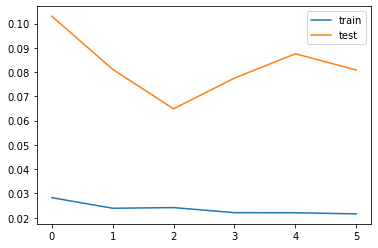

(124, 7)
(124, 7)
(124, 7)
score_train: [184.375] 172.2, 183.3, 181.8, 184.4, 176.7, 195.2, 195.7
(29, 1, 20)
score_test: [380.503] 337.3, 288.0, 146.7, 248.0, 513.6, 473.1, 496.1

RMSE test:  380.50296638963624 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0931
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0902
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0745
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0744
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0613
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0785
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape            

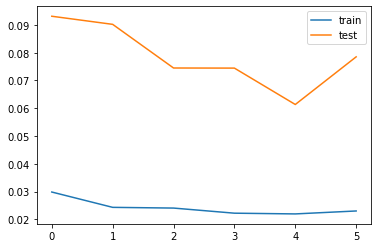

(124, 7)
(124, 7)
(124, 7)
score_train: [184.255] 172.9, 180.3, 190.3, 184.2, 181.3, 190.1, 189.9
(29, 1, 20)
score_test: [374.867] 379.7, 231.3, 141.3, 247.0, 509.0, 488.6, 455.1

RMSE test:  374.8669914283808 


Units CNN1:  249 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0779
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0805
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0729
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0707
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0577
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0784
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape             

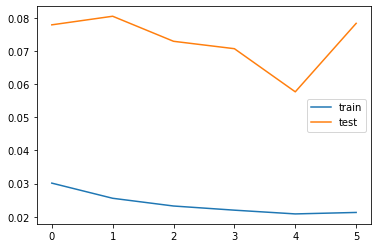

(124, 7)
(124, 7)
(124, 7)
score_train: [189.151] 174.4, 182.0, 217.6, 183.6, 185.7, 190.2, 187.6
(29, 1, 20)
score_test: [374.552] 391.2, 262.4, 168.0, 258.0, 493.0, 466.5, 452.3

RMSE test:  374.5519459465747 


Units CNN1:  247 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0885
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0856
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0858
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0684
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0205 - val_loss: 0.0523
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0879
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape             

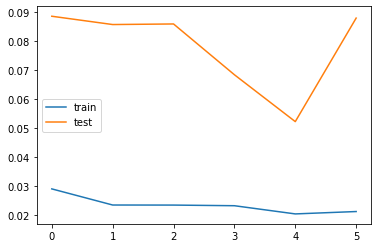

(124, 7)
(124, 7)
(124, 7)
score_train: [189.730] 178.4, 178.2, 192.4, 189.0, 187.1, 208.0, 193.4
(29, 1, 20)
score_test: [396.607] 440.4, 234.5, 176.9, 263.4, 493.6, 514.7, 492.9

RMSE test:  396.60715993389914 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 1s 5ms/step - loss: 0.0286 - val_loss: 0.0833
Epoch 2/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0246 - val_loss: 0.0694
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0546
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0585
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0581
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0639
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape            

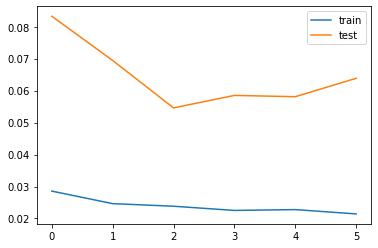

(124, 7)
(124, 7)
(124, 7)
score_train: [189.372] 170.6, 177.0, 200.4, 192.8, 189.6, 201.7, 191.5
(29, 1, 20)
score_test: [338.107] 264.4, 219.8, 161.0, 152.6, 510.8, 438.5, 423.8

RMSE test:  338.10652208150395 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0804
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0647
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0617
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0592
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0682
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0896
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape            

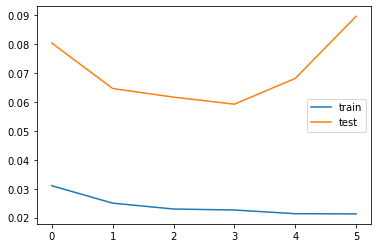

(124, 7)
(124, 7)
(124, 7)
score_train: [195.509] 182.5, 184.7, 198.7, 185.0, 199.6, 195.7, 219.9
(29, 1, 20)
score_test: [400.583] 382.6, 280.1, 179.8, 270.0, 547.8, 455.2, 534.7

RMSE test:  400.582603576323 

2  	7     	302.297	7.57828	298.507	317.453

Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0743
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0701
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0865
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0650
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0619
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0520
Model: "sequential_23"
_________________________________________________________________
Layer (type)

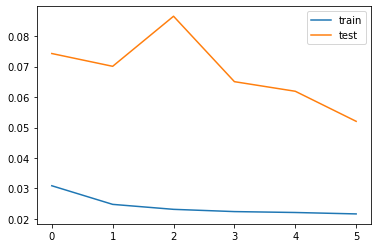

(124, 7)
(124, 7)
(124, 7)
score_train: [187.387] 171.8, 176.9, 180.9, 182.3, 193.7, 205.5, 198.2
(29, 1, 20)
score_test: [305.206] 311.2, 221.2, 149.6, 188.9, 357.5, 367.7, 430.4

RMSE test:  305.2059527229817 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 1s 5ms/step - loss: 0.0290 - val_loss: 0.0694
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0795
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0753
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0659
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0756
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0513
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape             

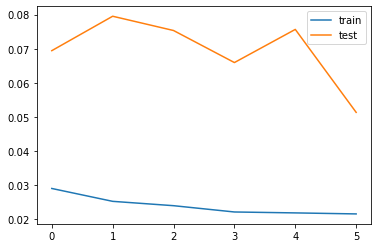

(124, 7)
(124, 7)
(124, 7)
score_train: [201.898] 214.0, 223.0, 184.1, 187.4, 196.0, 189.6, 215.5
(29, 1, 20)
score_test: [303.093] 224.9, 199.2, 147.4, 225.6, 389.5, 419.5, 390.5

RMSE test:  303.0932186063108 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0912
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.1021
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0741
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0649
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0696
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0710
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape             

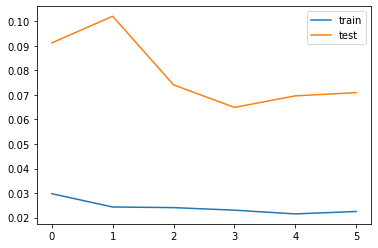

(124, 7)
(124, 7)
(124, 7)
score_train: [184.579] 165.8, 177.9, 190.2, 191.6, 180.7, 185.8, 198.2
(29, 1, 20)
score_test: [356.401] 337.3, 237.2, 152.9, 191.8, 531.8, 399.3, 465.5

RMSE test:  356.4013493413207 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0294 - val_loss: 0.0900
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0845
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0824
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0831
Epoch 5/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0216 - val_loss: 0.0658
Epoch 6/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0212 - val_loss: 0.0560
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape             

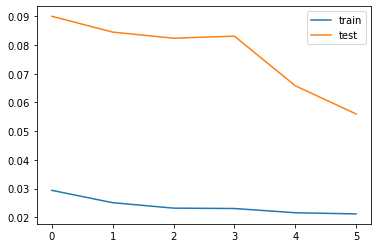

(124, 7)
(124, 7)
(124, 7)
score_train: [188.182] 171.9, 178.7, 193.9, 197.5, 181.1, 187.5, 204.6
(29, 1, 20)
score_test: [316.566] 312.6, 231.6, 129.2, 147.8, 423.9, 409.8, 405.0

RMSE test:  316.5663969693546 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0777
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0657
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0827
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0625
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0649
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0607
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape             

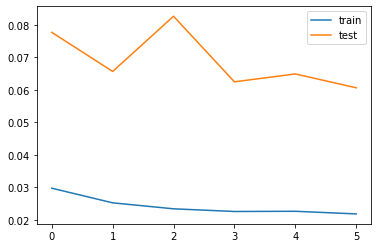

(124, 7)
(124, 7)
(124, 7)
score_train: [183.371] 173.8, 174.0, 178.6, 195.3, 179.5, 189.2, 191.9
(29, 1, 20)
score_test: [329.566] 254.1, 256.2, 148.2, 148.6, 435.2, 407.3, 480.3

RMSE test:  329.56569486499797 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0278 - val_loss: 0.0675
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0707
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0710
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0763
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0613
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0635
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape            

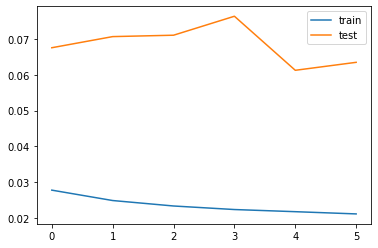

(124, 7)
(124, 7)
(124, 7)
score_train: [185.170] 170.5, 189.9, 178.1, 179.9, 184.0, 199.0, 193.2
(29, 1, 20)
score_test: [337.104] 298.9, 189.8, 151.5, 208.1, 485.7, 378.1, 474.3

RMSE test:  337.1038429612358 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0305 - val_loss: 0.1098
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0897
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0722
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0723
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0693
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0611
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape             

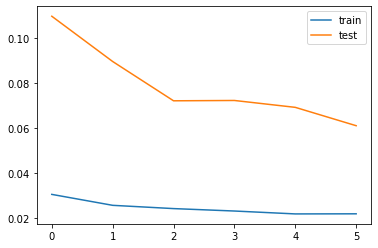

(124, 7)
(124, 7)
(124, 7)
score_train: [184.384] 168.0, 190.3, 179.6, 189.4, 178.0, 193.3, 190.6
(29, 1, 20)
score_test: [330.696] 318.3, 227.3, 146.3, 203.4, 461.7, 386.6, 432.6

RMSE test:  330.69553329260964 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 1s 5ms/step - loss: 0.0302 - val_loss: 0.0792
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0926
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0738
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0676
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0732
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0689
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape            

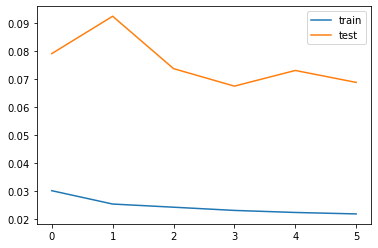

(124, 7)
(124, 7)
(124, 7)
score_train: [184.537] 172.9, 188.5, 182.4, 182.9, 179.8, 188.7, 195.7
(29, 1, 20)
score_test: [351.264] 327.3, 298.8, 149.7, 225.8, 473.1, 421.0, 439.1

RMSE test:  351.26432566886666 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0284 - val_loss: 0.0857
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0854
Epoch 3/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0229 - val_loss: 0.0927
Epoch 4/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0227 - val_loss: 0.0498
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0661
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0660
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape            

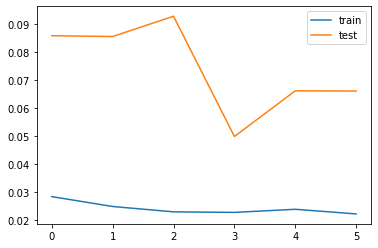

(124, 7)
(124, 7)
(124, 7)
score_train: [182.055] 171.9, 175.9, 179.6, 183.6, 180.5, 191.2, 190.9
(29, 1, 20)
score_test: [343.709] 371.3, 259.1, 135.3, 228.7, 456.3, 377.7, 447.8

RMSE test:  343.70943898436224 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0297 - val_loss: 0.0854
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0735
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0810
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0691
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0850
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0636
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape            

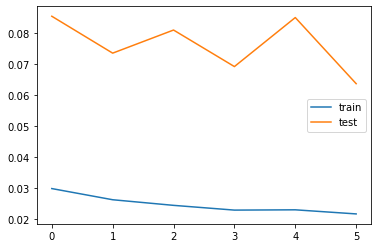

(124, 7)
(124, 7)
(124, 7)
score_train: [191.667] 167.7, 187.4, 228.1, 180.4, 179.9, 200.5, 191.7
(29, 1, 20)
score_test: [337.499] 344.2, 226.6, 165.6, 226.0, 472.6, 373.6, 431.4

RMSE test:  337.4985677539642 

3  	10    	298.507	0      	298.507	298.507

Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0718
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0593
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0625
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0736
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0693
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0612
Model: "sequential_33"
_________________________________________________________________
Layer (type

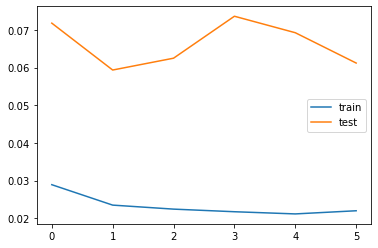

(124, 7)
(124, 7)
(124, 7)
score_train: [187.425] 171.0, 177.9, 210.2, 182.0, 177.8, 195.6, 194.5
(29, 1, 20)
score_test: [331.005] 296.1, 258.3, 175.8, 176.1, 460.9, 392.9, 428.8

RMSE test:  331.0051018136668 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0985
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0792
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0764
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0861
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0779
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0534
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape             

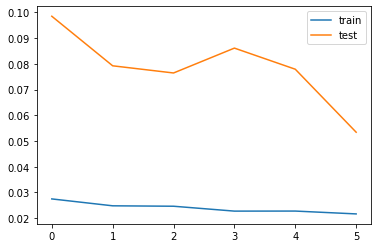

(124, 7)
(124, 7)
(124, 7)
score_train: [187.217] 167.6, 196.9, 184.5, 181.7, 188.9, 187.5, 201.5
(29, 1, 20)
score_test: [309.239] 318.1, 216.5, 128.9, 175.7, 402.6, 412.4, 376.5

RMSE test:  309.23944102427487 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.0945
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0797
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0711
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0672
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0554
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0635
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape            

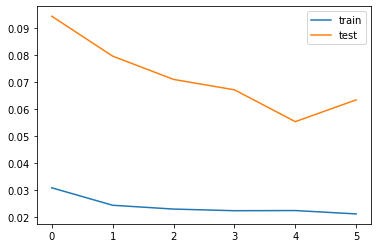

(124, 7)
(124, 7)
(124, 7)
score_train: [184.209] 167.0, 175.4, 192.6, 187.5, 178.5, 196.5, 190.1
(29, 1, 20)
score_test: [337.083] 268.6, 256.8, 151.5, 263.8, 410.3, 448.4, 442.0

RMSE test:  337.0829358454393 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0909
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0887
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0574
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0616
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0594
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0210 - val_loss: 0.0720
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape             

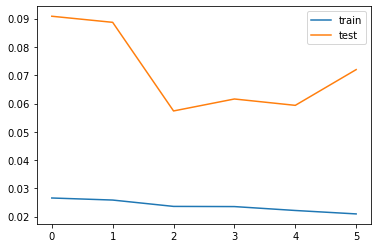

(124, 7)
(124, 7)
(124, 7)
score_train: [184.980] 170.2, 179.7, 182.3, 181.8, 195.1, 196.3, 188.2
(29, 1, 20)
score_test: [358.994] 341.5, 241.3, 163.5, 215.6, 503.9, 455.3, 439.1

RMSE test:  358.9943470196188 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.1096
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0675
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0663
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0698
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0767
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0208 - val_loss: 0.0694
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape             

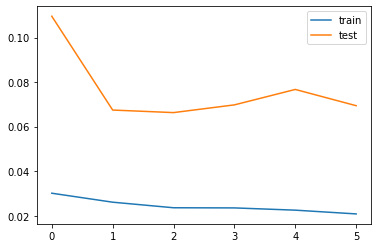

(124, 7)
(124, 7)
(124, 7)
score_train: [185.357] 166.4, 177.3, 177.8, 182.2, 199.0, 198.1, 194.2
(29, 1, 20)
score_test: [352.505] 298.0, 224.6, 146.4, 242.0, 493.2, 449.6, 453.0

RMSE test:  352.50472389103925 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0840
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0658
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0690
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0603
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0519
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0680
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape            

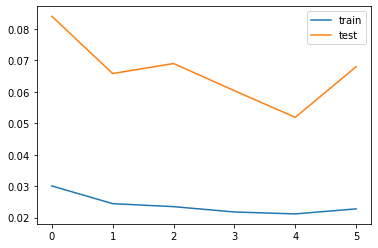

(124, 7)
(124, 7)
(124, 7)
score_train: [185.797] 167.8, 184.5, 179.4, 187.0, 192.6, 191.2, 196.5
(29, 1, 20)
score_test: [348.805] 305.4, 272.4, 135.8, 208.2, 413.9, 440.3, 507.2

RMSE test:  348.8054132409796 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0951
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0867
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0776
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0712
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0682
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0506
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape             

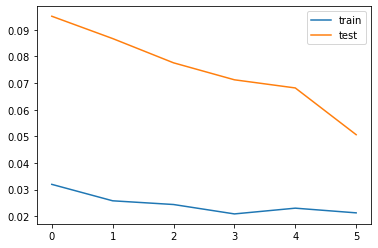

(124, 7)
(124, 7)
(124, 7)
score_train: [186.357] 169.9, 183.9, 186.7, 190.3, 185.2, 196.2, 191.3
(29, 1, 20)
score_test: [301.058] 286.6, 253.3, 140.2, 188.1, 360.9, 367.1, 410.0

RMSE test:  301.05775086488 

4  	7     	298.507	0      	298.507	298.507

Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.1016
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0876
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0896
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0845
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0663
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0571
Model: "sequential_40"
_________________________________________________________________
Layer (type) 

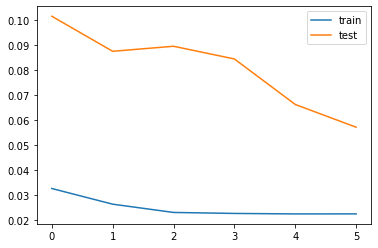

(124, 7)
(124, 7)
(124, 7)
score_train: [192.353] 179.1, 189.3, 180.9, 188.0, 202.5, 194.3, 210.4
(29, 1, 20)
score_test: [319.829] 324.6, 215.5, 139.5, 274.9, 393.1, 372.5, 419.4

RMSE test:  319.8289976301384 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0886
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0901
Epoch 3/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0233 - val_loss: 0.0691
Epoch 4/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0227 - val_loss: 0.0635
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0666
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0525
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape             

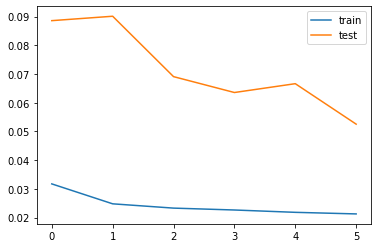

(124, 7)
(124, 7)
(124, 7)
score_train: [183.082] 168.4, 178.2, 188.5, 185.2, 179.5, 186.6, 194.1
(29, 1, 20)
score_test: [306.687] 315.0, 196.6, 145.7, 201.7, 424.6, 379.9, 366.0

RMSE test:  306.68738136038456 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0913
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0856
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0710
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0528
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0569
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0826
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape            

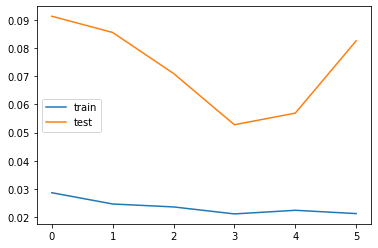

(124, 7)
(124, 7)
(124, 7)
score_train: [192.990] 173.7, 193.8, 202.6, 181.9, 194.9, 191.2, 210.5
(29, 1, 20)
score_test: [384.556] 352.3, 299.9, 166.3, 196.8, 541.4, 468.8, 491.8

RMSE test:  384.55558353682414 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.1003
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0608
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0829
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0570
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0569
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0740
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape            

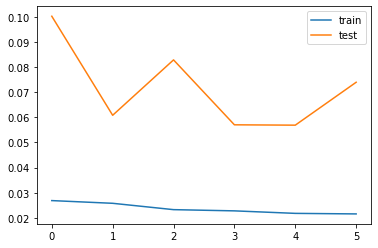

(124, 7)
(124, 7)
(124, 7)
score_train: [188.993] 166.7, 174.6, 201.3, 188.7, 201.6, 188.8, 198.4
(29, 1, 20)
score_test: [363.907] 308.9, 269.0, 171.1, 259.5, 543.6, 351.1, 493.8

RMSE test:  363.9065535345879 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0793
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0973
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0807
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0867
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0601
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0749
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape             

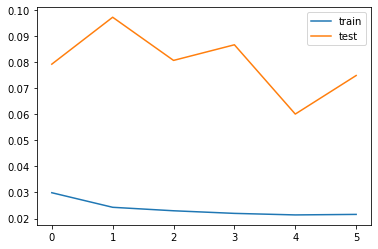

(124, 7)
(124, 7)
(124, 7)
score_train: [185.311] 167.8, 172.8, 176.3, 181.5, 193.3, 193.1, 208.9
(29, 1, 20)
score_test: [366.270] 312.8, 230.5, 137.1, 226.7, 531.8, 407.1, 519.1

RMSE test:  366.2700188319107 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0765
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0691
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0830
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0789
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0591
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0523
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape             

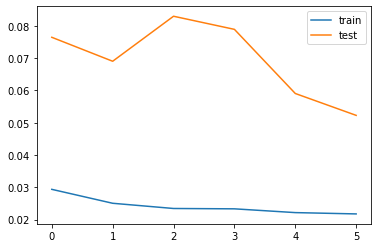

(124, 7)
(124, 7)
(124, 7)
score_train: [184.375] 177.7, 178.8, 182.6, 182.7, 188.4, 186.0, 193.9
(29, 1, 20)
score_test: [305.937] 279.9, 234.2, 148.4, 187.3, 364.2, 407.3, 407.8

RMSE test:  305.9369366792385 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0945
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0718
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0683
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0691
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0580
Epoch 6/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0222 - val_loss: 0.0622
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape             

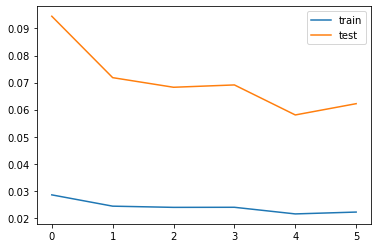

(124, 7)
(124, 7)
(124, 7)
score_train: [183.078] 173.7, 182.9, 176.8, 187.2, 180.9, 189.0, 190.4
(29, 1, 20)
score_test: [333.723] 276.7, 200.6, 139.9, 267.4, 440.9, 442.6, 425.9

RMSE test:  333.72312855990396 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.1228
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0801
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0833
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0500
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0698
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0206 - val_loss: 0.0711
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape            

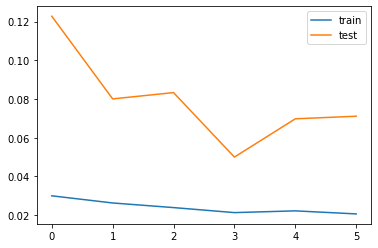

(124, 7)
(124, 7)
(124, 7)
score_train: [182.994] 169.6, 180.7, 178.3, 183.3, 186.7, 187.0, 194.4
(29, 1, 20)
score_test: [356.780] 323.7, 270.4, 141.9, 191.4, 483.6, 438.2, 480.0

RMSE test:  356.77952215323563 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0997
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0874
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0845
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0547
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0666
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0659
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape            

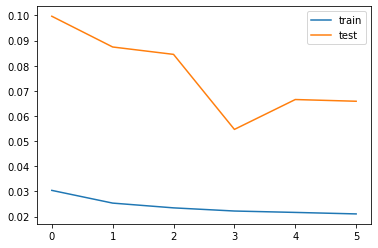

(124, 7)
(124, 7)
(124, 7)
score_train: [183.285] 182.7, 175.1, 180.7, 184.2, 179.1, 188.0, 192.7
(29, 1, 20)
score_test: [343.395] 371.7, 269.4, 146.7, 200.1, 469.3, 424.2, 391.1

RMSE test:  343.39455981610223 

5  	9     	298.507	0      	298.507	298.507

Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 1s 5ms/step - loss: 0.0279 - val_loss: 0.0750
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0579
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0726
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0683
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0654
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0575
Model: "sequential_49"
_________________________________________________________________
Layer (typ

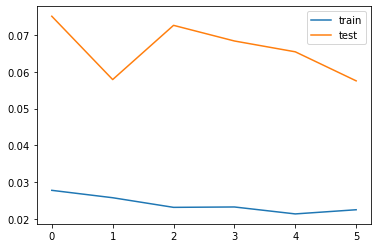

(124, 7)
(124, 7)
(124, 7)
score_train: [187.757] 192.1, 176.1, 180.9, 188.6, 181.8, 202.6, 191.0
(29, 1, 20)
score_test: [320.887] 234.1, 255.9, 147.5, 269.2, 429.0, 379.4, 422.2

RMSE test:  320.88719983576783 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0902
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0887
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0797
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0620
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0687
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0824
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape            

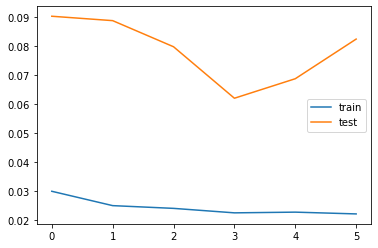

(124, 7)
(124, 7)
(124, 7)
score_train: [187.373] 170.7, 179.8, 184.5, 193.7, 186.5, 202.4, 192.3
(29, 1, 20)
score_test: [383.978] 328.7, 279.5, 159.9, 267.3, 483.0, 507.3, 508.2

RMSE test:  383.97821237619485 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 4ms/step - loss: 0.0305 - val_loss: 0.0858
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0839
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0763
Epoch 4/6
124/124 [==============================] - 0s 4ms/step - loss: 0.0221 - val_loss: 0.0612
Epoch 5/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0223 - val_loss: 0.0753
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0677
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape            

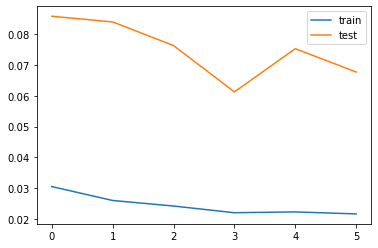

(124, 7)
(124, 7)
(124, 7)
score_train: [183.518] 168.1, 181.2, 186.4, 190.4, 178.6, 186.9, 192.0
(29, 1, 20)
score_test: [348.123] 323.6, 265.5, 154.9, 275.7, 443.6, 426.7, 440.8

RMSE test:  348.1230046402881 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0320 - val_loss: 0.0877
Epoch 2/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0676
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0974
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0601
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0619
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0668
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape             

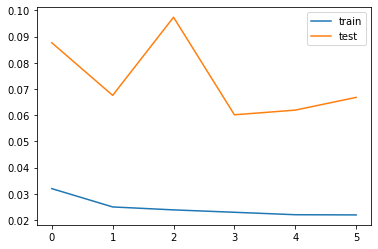

(124, 7)
(124, 7)
(124, 7)
score_train: [187.537] 167.4, 182.8, 180.0, 188.8, 182.1, 216.7, 191.3
(29, 1, 20)
score_test: [345.804] 294.6, 268.8, 132.3, 237.8, 477.1, 455.7, 410.8

RMSE test:  345.80360792289275 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0964
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0654
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0703
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0656
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0765
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0497
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape            

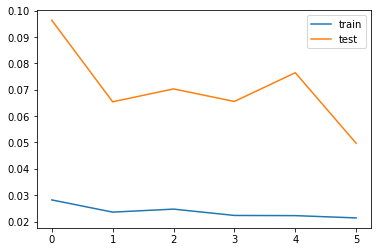

(124, 7)
(124, 7)
(124, 7)
score_train: [183.552] 168.5, 174.8, 181.0, 179.5, 193.0, 197.0, 189.4
(29, 1, 20)
score_test: [298.265] 294.7, 221.6, 128.7, 157.7, 361.1, 360.1, 430.4

RMSE test:  298.2648671010053 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0832
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0872
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0669
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0786
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0639
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0616
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape             

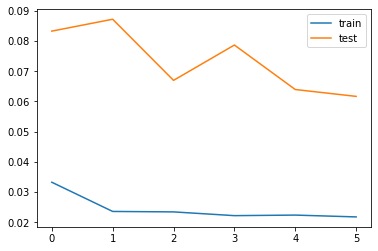

(124, 7)
(124, 7)
(124, 7)
score_train: [189.854] 204.5, 190.0, 183.3, 181.4, 180.4, 195.3, 192.8
(29, 1, 20)
score_test: [332.188] 242.3, 186.2, 134.8, 227.3, 474.2, 396.0, 477.0

RMSE test:  332.18786917508123 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0929
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0704
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0686
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0654
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0591
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0602
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape            

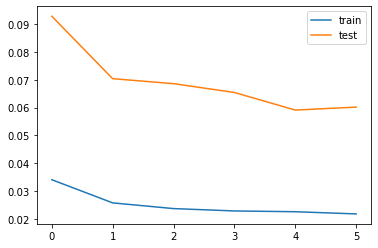

(124, 7)
(124, 7)
(124, 7)
score_train: [186.656] 177.4, 182.6, 182.4, 182.3, 184.4, 191.4, 204.9
(29, 1, 20)
score_test: [328.185] 380.6, 271.3, 145.5, 198.8, 381.6, 390.1, 420.7

RMSE test:  328.18534343579057 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0823
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0717
Epoch 3/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0239 - val_loss: 0.0697
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0940
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0642
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0627
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape            

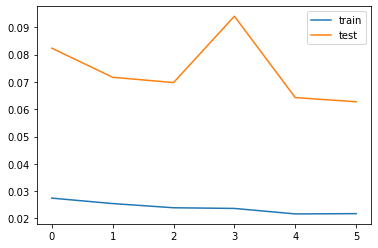

(124, 7)
(124, 7)
(124, 7)
score_train: [190.960] 171.1, 214.9, 181.2, 185.5, 181.4, 193.7, 205.4
(29, 1, 20)
score_test: [335.123] 309.8, 198.2, 146.6, 217.8, 480.0, 400.1, 437.6

RMSE test:  335.12279893475124 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0789
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0719
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0605
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0788
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0512
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0578
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape            

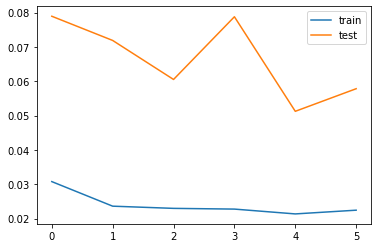

(124, 7)
(124, 7)
(124, 7)
score_train: [184.749] 173.1, 176.8, 178.8, 185.9, 183.9, 186.2, 206.4
(29, 1, 20)
score_test: [321.766] 336.1, 244.4, 142.3, 215.8, 410.9, 404.3, 391.1

RMSE test:  321.7655044935801 

6  	9     	298.386	0.121274	298.265	298.507

Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0970
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0731
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0899
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0839
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0734
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0645
Model: "sequential_58"
_________________________________________________________________
Layer (typ

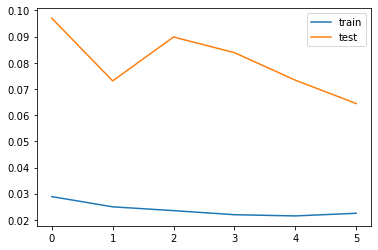

(124, 7)
(124, 7)
(124, 7)
score_train: [185.591] 172.5, 183.5, 196.2, 182.9, 183.5, 186.2, 193.3
(29, 1, 20)
score_test: [339.699] 289.2, 228.0, 151.9, 229.3, 504.6, 404.0, 422.7

RMSE test:  339.69916717090507 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0763
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0776
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0611
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0618
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0564
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0600
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape            

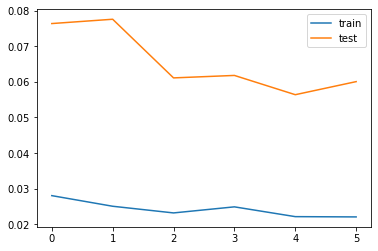

(124, 7)
(124, 7)
(124, 7)
score_train: [182.984] 169.2, 180.6, 179.8, 186.5, 178.5, 190.5, 194.6
(29, 1, 20)
score_test: [327.875] 287.4, 270.8, 137.4, 159.6, 475.7, 384.5, 422.0

RMSE test:  327.8753213896505 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0857
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.1082
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0742
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0635
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0630
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0593
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape             

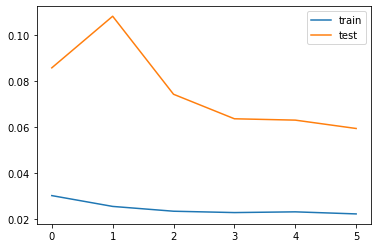

(124, 7)
(124, 7)
(124, 7)
score_train: [185.373] 167.4, 192.6, 178.6, 183.6, 190.6, 193.5, 189.8
(29, 1, 20)
score_test: [325.844] 291.8, 315.1, 149.9, 170.5, 417.0, 394.1, 421.9

RMSE test:  325.8444890206594 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0801
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0670
Epoch 3/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0238 - val_loss: 0.0673
Epoch 4/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0213 - val_loss: 0.0480
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0527
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0590
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape             

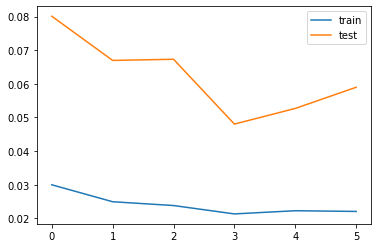

(124, 7)
(124, 7)
(124, 7)
score_train: [182.365] 170.5, 176.2, 179.6, 184.3, 189.5, 185.1, 190.4
(29, 1, 20)
score_test: [324.950] 265.7, 217.8, 135.6, 218.4, 482.9, 374.7, 426.0

RMSE test:  324.95012230843145 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0297 - val_loss: 0.0777
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0681
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0686
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0627
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0634
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0609
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape            

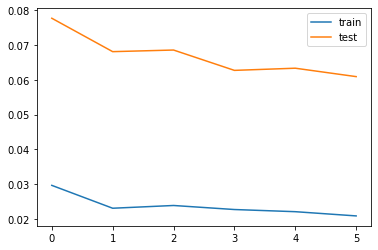

(124, 7)
(124, 7)
(124, 7)
score_train: [186.838] 171.3, 179.7, 187.7, 185.3, 180.2, 191.1, 210.1
(29, 1, 20)
score_test: [330.304] 340.0, 206.5, 158.8, 207.6, 464.1, 409.1, 392.9

RMSE test:  330.303531592086 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.1039
Epoch 2/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0252 - val_loss: 0.0825
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0758
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0720
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0895
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0603
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              

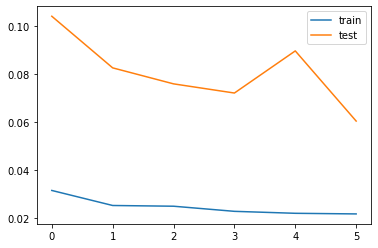

(124, 7)
(124, 7)
(124, 7)
score_train: [197.826] 185.5, 208.4, 211.0, 185.4, 182.0, 203.8, 206.3
(29, 1, 20)
score_test: [328.578] 281.5, 207.8, 161.6, 228.4, 482.0, 375.4, 426.4

RMSE test:  328.57823105707075 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0856
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0811
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0746
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0687
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0783
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0198 - val_loss: 0.0601
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape            

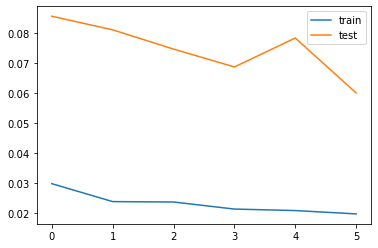

(124, 7)
(124, 7)
(124, 7)
score_train: [184.732] 171.3, 178.7, 188.6, 186.2, 183.3, 193.4, 190.6
(29, 1, 20)
score_test: [327.906] 305.3, 204.8, 144.3, 225.7, 444.5, 410.2, 424.1

RMSE test:  327.9064435138474 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0756
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0662
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0590
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0648
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0620
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0698
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape             

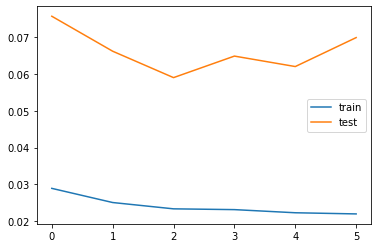

(124, 7)
(124, 7)
(124, 7)
score_train: [187.541] 178.3, 186.2, 180.9, 201.4, 181.1, 193.5, 190.3
(29, 1, 20)
score_test: [353.619] 331.5, 295.1, 148.3, 343.6, 392.9, 439.6, 436.7

RMSE test:  353.61857501251603 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0747
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0625
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0513
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0622
Epoch 5/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0214 - val_loss: 0.0619
Epoch 6/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0215 - val_loss: 0.0471
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape            

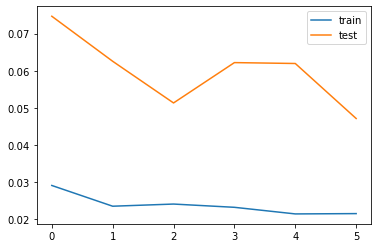

(124, 7)
(124, 7)
(124, 7)
score_train: [193.015] 172.1, 178.5, 181.1, 183.6, 233.2, 197.8, 198.2
(29, 1, 20)
score_test: [290.457] 282.5, 253.8, 134.2, 199.5, 312.8, 366.5, 395.5

RMSE test:  290.45705107473856 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0301 - val_loss: 0.0877
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0784
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0735
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0860
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0865
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0672
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape            

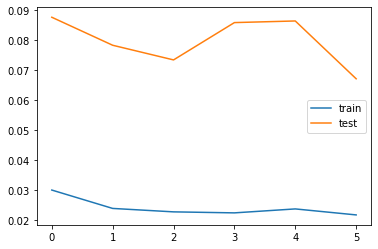

(124, 7)
(124, 7)
(124, 7)
score_train: [185.171] 174.2, 177.5, 183.0, 191.5, 182.3, 193.8, 193.0
(29, 1, 20)
score_test: [346.896] 318.7, 245.0, 156.2, 272.2, 414.6, 482.4, 421.5

RMSE test:  346.8958742222469 

7  	10    	296.703	3.12313 	290.457	298.265

Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.1022
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0747
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0786
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0573
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0810
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0891
Model: "sequential_68"
_________________________________________________________________
Layer (typ

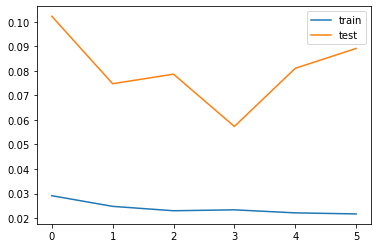

(124, 7)
(124, 7)
(124, 7)
score_train: [193.705] 176.8, 179.6, 196.7, 202.0, 189.2, 192.6, 216.3
(29, 1, 20)
score_test: [399.344] 386.8, 297.4, 179.1, 295.8, 496.0, 497.1, 515.3

RMSE test:  399.34433948100946 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0669
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0700
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0805
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0466
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0641
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0207 - val_loss: 0.0582
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape            

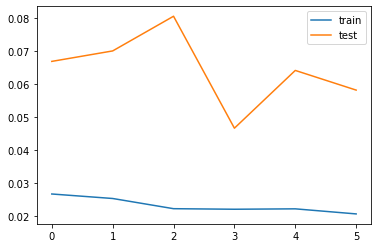

(124, 7)
(124, 7)
(124, 7)
score_train: [181.355] 169.2, 178.3, 180.8, 183.6, 178.8, 187.5, 190.5
(29, 1, 20)
score_test: [322.698] 270.5, 245.4, 150.7, 194.5, 444.3, 407.2, 414.5

RMSE test:  322.69786409563966 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0887
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0916
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0750
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0947
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0623
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0783
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape            

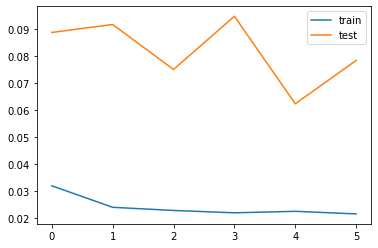

(124, 7)
(124, 7)
(124, 7)
score_train: [189.379] 170.6, 183.1, 190.9, 205.7, 184.2, 190.6, 198.6
(29, 1, 20)
score_test: [374.469] 367.9, 281.2, 154.8, 294.0, 494.4, 421.9, 484.1

RMSE test:  374.4694777782783 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0711
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0639
Epoch 3/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0242 - val_loss: 0.0741
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0699
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0682
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0684
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape             

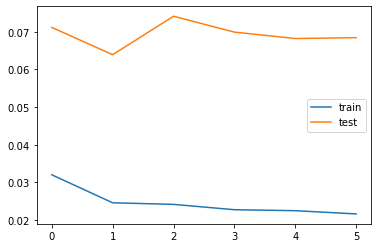

(124, 7)
(124, 7)
(124, 7)
score_train: [185.158] 167.5, 179.2, 181.5, 183.0, 202.6, 186.6, 193.7
(29, 1, 20)
score_test: [349.957] 313.4, 218.5, 155.4, 240.2, 525.4, 427.7, 413.0

RMSE test:  349.9567228543022 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0870
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0759
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0816
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0701
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0630
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0782
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape             

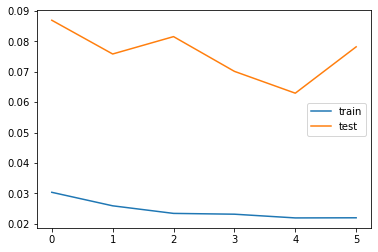

(124, 7)
(124, 7)
(124, 7)
score_train: [189.802] 181.8, 176.6, 182.7, 182.4, 192.3, 195.4, 214.8
(29, 1, 20)
score_test: [374.182] 268.7, 202.3, 138.5, 280.0, 509.0, 495.6, 514.5

RMSE test:  374.1824406207856 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0732
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0873
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0705
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0665
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0676
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0569
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape             

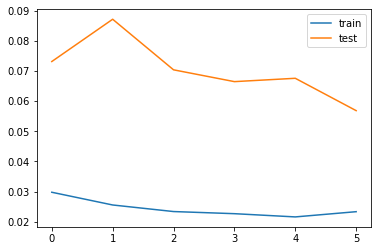

(124, 7)
(124, 7)
(124, 7)
score_train: [189.143] 169.9, 192.8, 180.1, 203.5, 195.3, 189.0, 191.6
(29, 1, 20)
score_test: [319.145] 321.1, 192.0, 148.2, 164.2, 378.3, 414.9, 457.0

RMSE test:  319.14531670090486 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0939
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0697
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0851
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0750
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0609
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0676
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape            

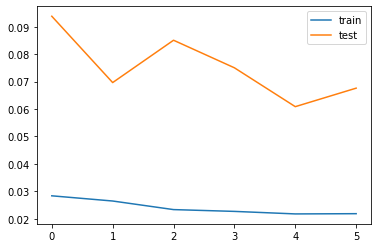

(124, 7)
(124, 7)
(124, 7)
score_train: [181.453] 169.3, 175.7, 177.0, 180.0, 179.1, 197.3, 190.3
(29, 1, 20)
score_test: [347.929] 342.0, 236.0, 149.8, 293.8, 425.5, 439.6, 437.9

RMSE test:  347.9291182579234 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0896
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0772
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0761
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0747
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0681
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0660
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape             

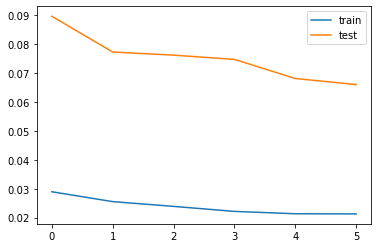

(124, 7)
(124, 7)
(124, 7)
score_train: [181.912] 172.9, 177.6, 179.5, 183.6, 184.3, 185.4, 189.7
(29, 1, 20)
score_test: [343.698] 300.2, 212.9, 130.4, 237.6, 481.6, 463.1, 414.2

RMSE test:  343.6983649359489 

8  	8     	292.019	3.12313 	290.457	298.265

Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.1058
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0881
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0893
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0785
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0794
Epoch 6/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0208 - val_loss: 0.0762
Model: "sequential_76"
_________________________________________________________________
Layer (typ

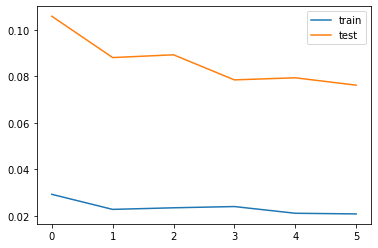

(124, 7)
(124, 7)
(124, 7)
score_train: [186.072] 172.7, 180.5, 190.3, 185.9, 184.5, 187.3, 200.1
(29, 1, 20)
score_test: [369.345] 353.7, 299.7, 149.2, 302.2, 418.9, 444.6, 503.3

RMSE test:  369.3447107481583 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0314 - val_loss: 0.0976
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0841
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0734
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0678
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0634
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0806
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape             

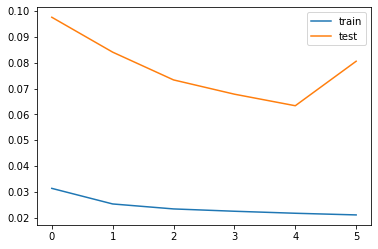

(124, 7)
(124, 7)
(124, 7)
score_train: [186.338] 169.2, 177.7, 180.3, 186.0, 196.3, 201.5, 191.3
(29, 1, 20)
score_test: [379.816] 347.1, 274.1, 143.9, 221.9, 526.9, 491.8, 474.1

RMSE test:  379.8158277587939 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0289 - val_loss: 0.0873
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0688
Epoch 3/6
124/124 [==============================] - 0s 4ms/step - loss: 0.0231 - val_loss: 0.0863
Epoch 4/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0229 - val_loss: 0.0840
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0672
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0207 - val_loss: 0.0589
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape             

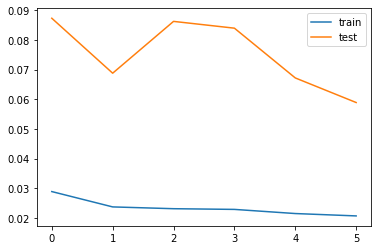

(124, 7)
(124, 7)
(124, 7)
score_train: [187.270] 167.8, 188.7, 195.0, 180.0, 178.5, 195.4, 203.0
(29, 1, 20)
score_test: [324.757] 321.9, 217.9, 157.6, 253.4, 421.4, 381.5, 418.4

RMSE test:  324.7572235736847 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0298 - val_loss: 0.0756
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0755
Epoch 3/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0228 - val_loss: 0.0703
Epoch 4/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0227 - val_loss: 0.0693
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0795
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0931
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape             

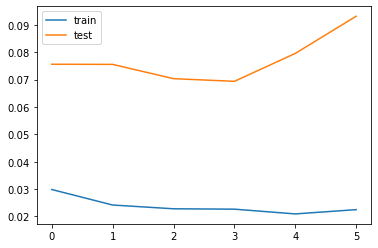

(124, 7)
(124, 7)
(124, 7)
score_train: [199.425] 177.1, 203.9, 207.3, 186.5, 191.1, 193.0, 232.2
(29, 1, 20)
score_test: [408.261] 364.0, 313.7, 189.1, 281.9, 515.5, 475.6, 573.3

RMSE test:  408.2612625689699 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0703
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0880
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0725
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0787
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0606
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0673
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape             

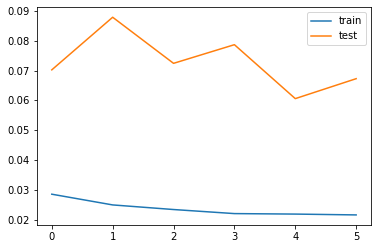

(124, 7)
(124, 7)
(124, 7)
score_train: [186.455] 170.7, 179.0, 182.7, 182.7, 185.1, 191.1, 211.2
(29, 1, 20)
score_test: [347.172] 264.2, 227.1, 144.5, 224.5, 451.6, 417.0, 522.7

RMSE test:  347.17155914961376 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 1s 4ms/step - loss: 0.0309 - val_loss: 0.0974
Epoch 2/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0251 - val_loss: 0.0800
Epoch 3/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0217 - val_loss: 0.0715
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0744
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0856
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0687
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape            

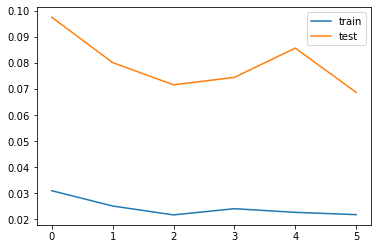

(124, 7)
(124, 7)
(124, 7)
score_train: [186.713] 170.3, 181.1, 190.2, 186.3, 197.4, 188.3, 192.2
(29, 1, 20)
score_test: [350.577] 281.2, 235.5, 132.3, 194.0, 516.6, 448.2, 450.5

RMSE test:  350.5770204475606 

9  	6     	291.238	2.34234 	290.457	298.265

Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0976
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0951
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0772
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0627
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0624
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0563
Model: "sequential_82"
_________________________________________________________________
Layer (typ

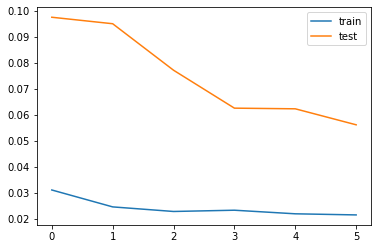

(124, 7)
(124, 7)
(124, 7)
score_train: [188.090] 176.7, 178.8, 179.0, 187.6, 200.6, 202.5, 189.7
(29, 1, 20)
score_test: [317.402] 266.8, 284.1, 136.4, 152.0, 411.3, 390.9, 435.5

RMSE test:  317.4019648469875 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0945
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0876
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0733
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0691
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0811
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0717
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape             

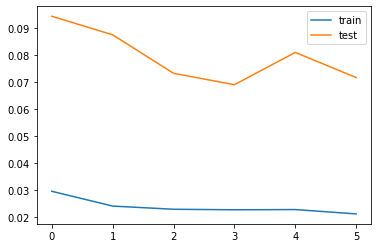

(124, 7)
(124, 7)
(124, 7)
score_train: [185.259] 202.6, 175.1, 179.6, 180.5, 181.0, 186.2, 190.5
(29, 1, 20)
score_test: [358.387] 394.6, 228.2, 154.2, 231.1, 474.5, 441.8, 440.2

RMSE test:  358.3874418192359 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0858
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0843
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0702
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0593
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0602
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0576
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape             

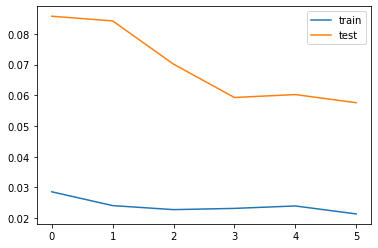

(124, 7)
(124, 7)
(124, 7)
score_train: [185.439] 173.9, 183.1, 181.7, 180.1, 198.0, 189.0, 191.2
(29, 1, 20)
score_test: [321.098] 296.4, 201.3, 141.4, 230.9, 358.2, 439.0, 446.1

RMSE test:  321.098045652024 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.1029
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0966
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0874
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0741
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0596
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0664
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              

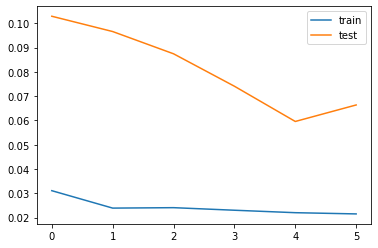

(124, 7)
(124, 7)
(124, 7)
score_train: [181.209] 166.3, 175.1, 178.3, 181.7, 188.7, 185.9, 191.3
(29, 1, 20)
score_test: [344.699] 305.8, 254.4, 133.9, 218.5, 409.6, 447.5, 489.8

RMSE test:  344.6991112710537 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 4ms/step - loss: 0.0306 - val_loss: 0.0923
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0794
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0692
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0674
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0684
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0742
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape             

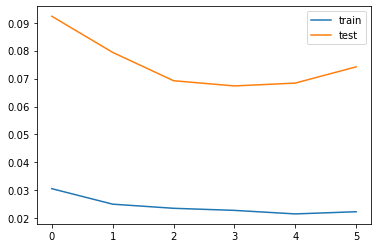

(124, 7)
(124, 7)
(124, 7)
score_train: [189.657] 169.9, 181.4, 181.3, 213.2, 197.5, 189.1, 192.2
(29, 1, 20)
score_test: [364.473] 301.6, 255.7, 138.5, 272.0, 510.6, 432.1, 482.7

RMSE test:  364.47303031197697 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0852
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0774
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0803
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0571
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0545
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0670
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape            

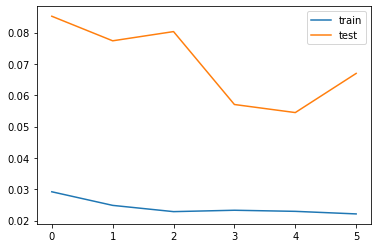

(124, 7)
(124, 7)
(124, 7)
score_train: [184.052] 173.4, 182.5, 181.4, 185.0, 181.6, 187.6, 196.0
(29, 1, 20)
score_test: [346.273] 328.9, 248.1, 134.9, 177.7, 470.4, 429.5, 462.7

RMSE test:  346.2727229318895 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 3ms/step - loss: 0.0302 - val_loss: 0.0725
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0587
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0583
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0716
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0513
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0210 - val_loss: 0.0795
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape             

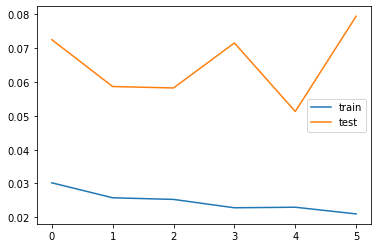

(124, 7)
(124, 7)
(124, 7)
score_train: [197.896] 170.8, 203.7, 208.7, 190.9, 198.2, 201.3, 209.0
(29, 1, 20)
score_test: [377.193] 315.5, 297.6, 175.5, 242.1, 530.0, 460.4, 475.0

RMSE test:  377.1931602620378 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0910
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0938
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0742
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0728
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0640
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0713
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape             

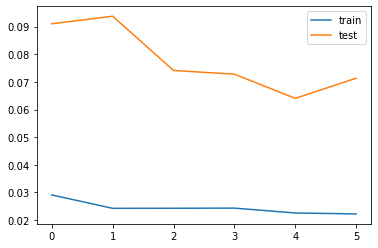

(124, 7)
(124, 7)
(124, 7)
score_train: [186.227] 170.0, 182.2, 199.4, 185.3, 186.1, 187.4, 191.8
(29, 1, 20)
score_test: [357.369] 317.8, 234.5, 188.6, 269.3, 467.4, 441.1, 465.8

RMSE test:  357.36899715572423 


Units CNN1:  255 ,Sequence size:  4
(124, 1, 20)
Epoch 1/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0899
Epoch 2/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0758
Epoch 3/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0563
Epoch 4/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0677
Epoch 5/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0715
Epoch 6/6
124/124 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0619
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape            

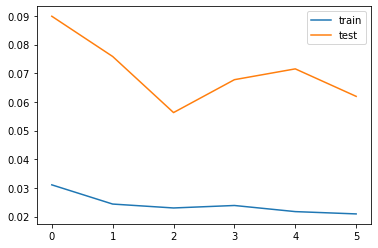

(124, 7)
(124, 7)
(124, 7)
score_train: [181.638] 170.6, 176.1, 179.2, 184.9, 182.9, 187.8, 189.3
(29, 1, 20)
score_test: [332.957] 279.5, 224.0, 145.8, 233.6, 446.8, 400.5, 460.3

RMSE test:  332.95720934859713 

10 	9     	290.457	0       	290.457	290.457


In [74]:
population_size = 10
num_generations = 10
# 8 bits for ltsm1 , 8 for lstm 2 , 6 for sequence length , 21 for features selections
# 8 bits for cnn1 ,8 bits for cnn2 , 8 bits for lstm 2 ,8 bits for lstm 2 , 6 bits for sequence length , 21 for features selections
gene_length =8 #58

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.9)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.7)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)
population = toolbox.population(n = population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
#param cxpb: The probability of mating two individuals.
#param mutpb: The probability of mutating an individual.
population , logbook  = algorithms.eaSimple(population, toolbox,halloffame=hof, cxpb = 0.7, mutpb = 0.6,stats=stats, ngen = num_generations, verbose = True)

In [75]:
print('Best score :', best_score)

Best score : 290.45705107473856


In [76]:
model=model_name
model.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 1, 255)            10455     
_________________________________________________________________
flatten_66 (Flatten)         (None, 255)               0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 255)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 7)                 1792      
Total params: 12,247
Trainable params: 12,247
Non-trainable params: 0
_________________________________________________________________


In [77]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# make a prediction
yhat = model.predict(X_test[[0,7,14,21,28]])
yhat.shape 

(5, 7)

In [78]:
yhat = yhat.reshape(-1, yhat.shape[-1])

In [79]:
#yhat

In [80]:
# invert scaling for forecast
y_test_pred = scaler2.inverse_transform(yhat)
#print(inv_yhat)
# invert scaling for actual
Y_test_true =Y_test[[0,7,14,21,28]]
Y_test_true = Y_test_true.reshape(-1, Y_test_true.shape[-1])
y_test_true= scaler2.inverse_transform(Y_test_true)

In [81]:
days

DatetimeIndex(['2020-07-12', '2020-07-13', '2020-07-14', '2020-07-15',
               '2020-07-16', '2020-07-17', '2020-07-18', '2020-07-19',
               '2020-07-20', '2020-07-21', '2020-07-22', '2020-07-23',
               '2020-07-24', '2020-07-25', '2020-07-26', '2020-07-27',
               '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31',
               '2020-08-01', '2020-08-02', '2020-08-03', '2020-08-04',
               '2020-08-05', '2020-08-06', '2020-08-07', '2020-08-08',
               '2020-08-09', '2020-08-10', '2020-08-11', '2020-08-12',
               '2020-08-13', '2020-08-14', '2020-08-15'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [82]:
test_res=pd.DataFrame()
test_res['Prediction']=y_test_pred.flatten()[0:35]
test_res['real']=y_test_true.flatten()[0:35]
test_res.set_index(days,inplace=True)

In [83]:
test_res

,Prediction,real
timestamp,,
2020-07-12,233.097549,214.000000
2020-07-13,210.416168,203.000015
2020-07-14,247.863754,190.999985
2020-07-15,264.167450,161.000000
2020-07-16,288.673035,165.000000
2020-07-17,279.290833,162.000000
2020-07-18,269.482178,302.000000
2020-07-19,241.989975,289.000000
2020-07-20,220.372467,220.999985


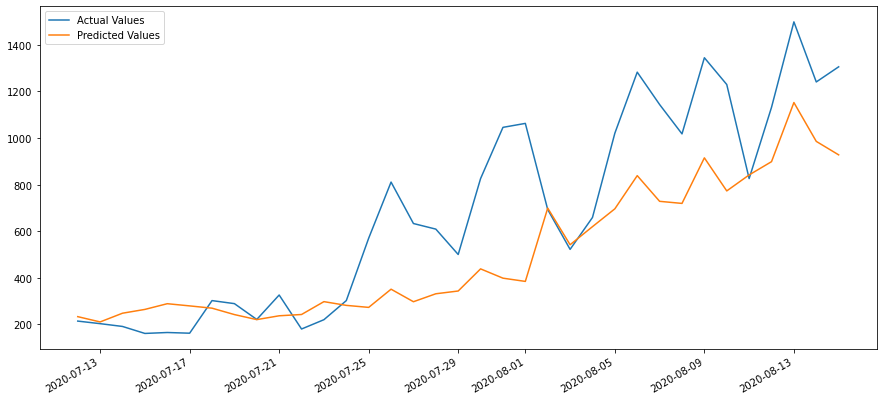

In [84]:

import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()




In [85]:
import numpy as np 
from sklearn import metrics
print('Test Metrics')
print('MSE:', round(metrics.mean_squared_error(test_res['real'], test_res['Prediction']), 2))
print('RMSE:',round( np.sqrt(metrics.mean_squared_error(test_res['real'], test_res['Prediction'])), 2))
print('MAE:', round(metrics.mean_absolute_error(test_res['real'], test_res['Prediction']), 2))
print('R Squared:', round( metrics.r2_score(test_res['real'], test_res['Prediction']), 2))
print('Max Error:',round(  metrics.max_error(test_res['real'], test_res['Prediction']), 2))


Test Metrics
MSE: 84365.3
RMSE: 290.46
MAE: 218.95
R Squared: 0.53
Max Error: 678.55


In [86]:
# make a prediction
y_train_pred = model.predict(X_train)
y_train_pred .shape

(124, 7)

In [87]:
y_train_pred = y_train_pred.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
y_train_pred.shape

(124, 7)

In [88]:

# invert scaling for forecast

y_train_pred = scaler2.inverse_transform(y_train_pred)
Y_train_true = Y_train.reshape((len(Y_train), n_out))

y_train_real = scaler2.inverse_transform(Y_train_true )

In [89]:

# Flatten for final errors
Y_train_pred_bis = y_train_pred.flatten()
Y_train_real_bis = y_train_real.flatten()

In [90]:
y_train_pred[0]

array([210.70804, 198.93045, 208.87587, 213.61552, 249.1141 , 234.87224,
       230.74953], dtype=float32)

In [91]:
#For plot 
#filter_indices = [0,7,14,21,28,35,42,49,56,63,70,77,84,91,98,105,112,119]
filter_indices = [0,7,14,21,28,35,42,49,56,63,70,77,84,91,98,105,112,119]
y_train_pred = y_train_pred [filter_indices ]

In [92]:
# Part of train dataset
y_train_real= y_train_real[filter_indices]
Y_train_pred = y_train_pred.flatten()
Y_train_real = y_train_real.flatten()

In [93]:
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
date_train = df.loc[mask].date.sort_index(axis = 0) 
X_train.shape

(124, 1, 20)

In [94]:
date_train.head(7)

22928   2020-03-02
22929   2020-03-03
22930   2020-03-04
22931   2020-03-05
22932   2020-03-06
22933   2020-03-07
22934   2020-03-08
Name: date, dtype: datetime64[ns]

In [95]:
taille_x = date_train.shape[0] - nb_seq
taille_x 

130

In [96]:
date_train = date_train.values.flatten()

In [97]:
prediction_train = pd.DataFrame(columns=['date_to_prediction','true_value','predict'])

In [98]:
Y_train_pred.shape

(126,)

In [99]:
Y_train_real.shape

(126,)

In [100]:
date_train.shape

(134,)

In [101]:
date_train[nb_seq:].shape

(130,)

In [102]:
suite_size = Y_train_real.shape[0]- date_train[nb_seq:].shape[0]
suite_size 

-4

In [103]:
Y_train_real[:-suite_size].shape

(4,)

In [104]:
date_train[nb_seq:].shape

(130,)

In [105]:
Y_train_pred[:-suite_size].shape

(4,)

In [106]:
Y_train_real[:-suite_size].shape

(4,)

In [107]:
date_trainX = date_train[nb_seq:]

In [108]:
date_trainX[0:Y_train_pred.shape[0]].shape

(126,)

In [109]:
prediction_train['date_to_prediction'] = date_trainX[0:Y_train_pred.shape[0]]
prediction_train['predict'] = Y_train_pred
prediction_train['true_value'] = Y_train_real


In [110]:
prediction_train['date_to_prediction'] = pd.to_datetime(prediction_train['date_to_prediction'], infer_datetime_format=True)

In [111]:
prediction_train.set_index('date_to_prediction',inplace=True)

In [112]:
prediction_train.head(20)

,true_value,predict
date_to_prediction,,
2020-03-06,163.080872,210.708038
2020-03-07,175.566101,198.930450
2020-03-08,175.566101,208.875870
2020-03-09,175.566101,213.615524
2020-03-10,175.566101,249.114105
2020-03-11,175.566101,234.872238
2020-03-12,167.242615,230.749527
2020-03-13,163.080872,200.728195
2020-03-14,163.080872,197.938034


In [113]:
prediction_train.tail(10)

,true_value,predict
date_to_prediction,,
2020-06-30,656.247314,970.137024
2020-07-01,666.651672,879.383667
2020-07-02,375.329742,689.348206
2020-07-03,853.929993,656.559143
2020-07-04,824.797852,550.835632
2020-07-05,1272.185059,647.419983
2020-07-06,978.782288,626.683411
2020-07-07,398.219299,818.319641
2020-07-08,161.000000,712.744202


"\nfig, ax = plt.subplots(figsize=(15,7))\nplt.plot(test_res.index, test_res['real'],  label='Actual Values')\nplt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')\n# If you don't like the break in the graph, change 90 to 89 in the above line\nplt.gcf().autofmt_xdate()\nplt.legend()\nplt.show()\n"

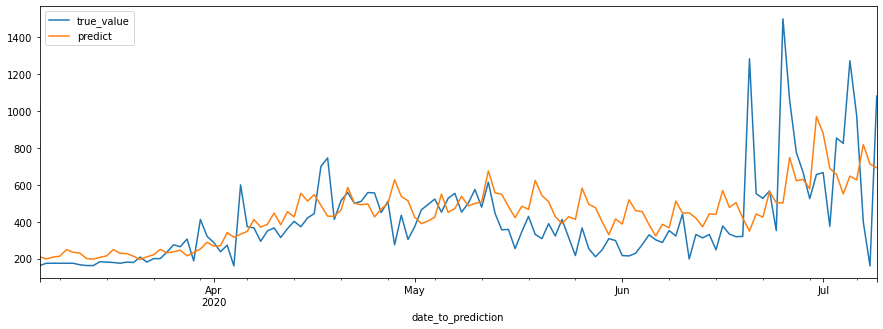

In [114]:
# Prédiction du train vs la réalité 
prediction_train.plot(figsize=(15,5))
'''
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
'''

In [115]:
print('Trains Metrics')
loss = tf.keras.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis )
print('MSE',"{:.2f}".format(loss))
rmse = tf.sqrt(tf.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis ))
print('RMSE',"{:.2f}".format(rmse))
loss2 = tf.keras.losses.MAE(Y_train_real_bis, Y_train_pred_bis )
print('MAE',"{:.2f}".format(loss2))
r2 =r2_score(Y_train_real_bis, Y_train_pred_bis )
print('R2',"{:.2f}".format(r2))
maxerror=max_error(Y_train_real_bis, Y_train_pred_bis )
print('maxError',"{:.2f}".format(maxerror))

Trains Metrics
MSE 37254.61
RMSE 193.01
MAE 129.03
R2 0.33
maxError 996.81
